## Openpose Example

This notebook shows an usage example of openpose with a random image of the dataset

In [1]:
%matplotlib inline
import cv2
import matplotlib
import pylab as plt
import numpy as np
import math
import tensorflow as tf
from numpy import ma
from tensorflow.keras.models import load_model
from models.model import get_model
from models.config import get_default_configuration
from scipy.ndimage.filters import gaussian_filter

Create the keras model load the weights file

In [2]:
weights_path = "models/weights.h5"
model = get_model(1.0, 224)
model.load_weights(weights_path)

Load a sample Image

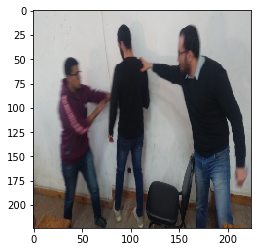

In [3]:
path = "example_image/example.jpg"
oriImg = cv2.imread(path) # B,G,R order
plt.imshow(oriImg[:,:,[2,1,0]])

Find Heatmaps

Input shape: (1, 224, 224, 3)
PAF shape: (1, 28, 28, 38)
Heatmap shape: (1, 28, 28, 19)


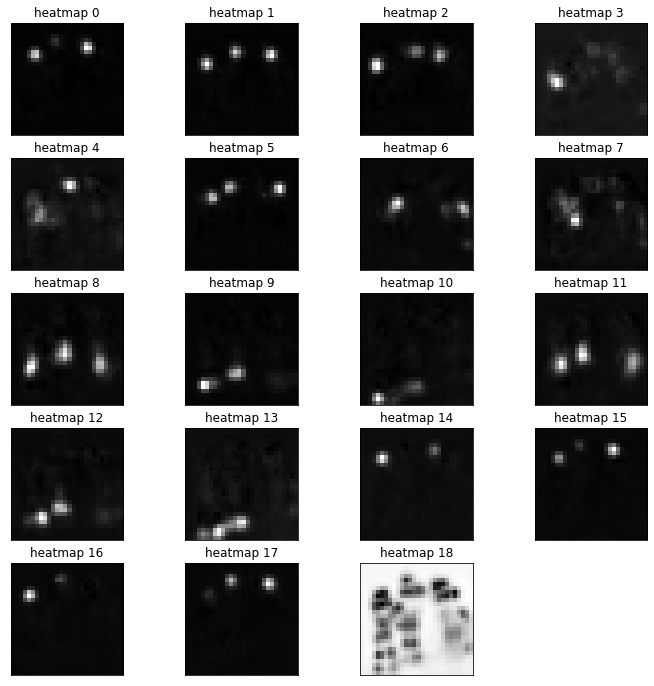

In [4]:
input_img = oriImg[np.newaxis,...] 
print("Input shape: " + str(input_img.shape))  
output_blobs = model.predict(input_img)
paf = output_blobs[2]
heatmap = output_blobs[3]
print("PAF shape: " + str(paf.shape))
print("Heatmap shape: " + str(heatmap.shape))

heatmap = heatmap[0]
paf = paf[0]

figure = plt.figure(figsize=(12, 12))

for i in range(19):

    plt.subplot(5, 4, i+1, title='heatmap {}'.format(i))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(heatmap[:, :, i], cmap='gray')

Heatmap + Image

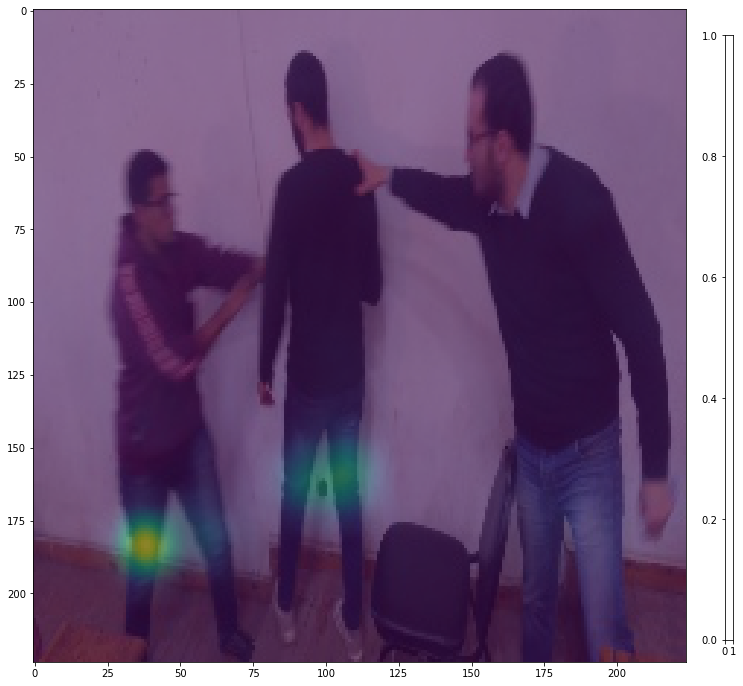

In [5]:
plt.imshow(oriImg[:,:,[2,1,0]])
h = cv2.resize(heatmap[:,:,9], (0,0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC)

plt.imshow(h, alpha=.5)

fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(12, 12)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])

Find Paf Vectors

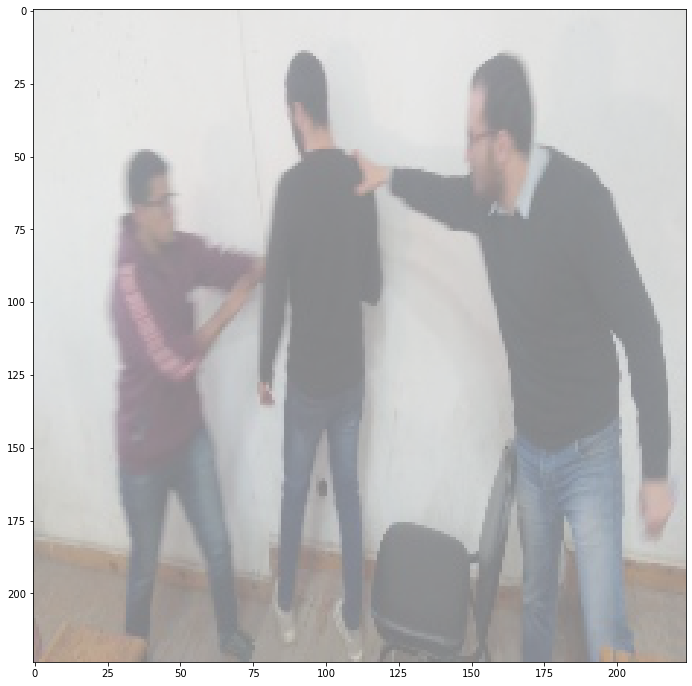

In [6]:
U = paf[:,:,16] * -1
V = paf[:,:,17]
U = cv2.resize(U, (0,0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
V = cv2.resize(V, (0,0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC)


X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
M = np.zeros(U.shape, dtype='bool')
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

# 1
plt.figure()
plt.imshow(oriImg[:,:,[2,1,0]], alpha = .5)
s = 5
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

Visualize detected body parts using heatmaps

In [7]:
all_peaks = []
peak_counter = 0
thre1 = 0.1
hashMap = dict() 
config = get_default_configuration()

for part_meta in config.body_parts.values():
    map = heatmap[:, :, part_meta.heatmap_idx]    
    
    map_left = np.zeros(map.shape)
    map_left[1:,:] = map[:-1,:]
    map_right = np.zeros(map.shape)
    map_right[:-1,:] = map[1:,:]
    map_up = np.zeros(map.shape)
    map_up[:,1:] = map[:,:-1]
    map_down = np.zeros(map.shape)
    map_down[:,:-1] = map[:,1:]
    
    peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > thre1))
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
    peaks_with_score = [x + (map[x[1],x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    for i in id:
        hashMap[i]=part_meta.body_part.name 
        
    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

In [8]:
#all_peaks contains all detected body parts
#Example: the first row represent Nose, in out image there are 3 people, so 3 noses
#Expected: [(11, 4, 0.15486531, 0), (18, 6, 0.78521746, 1), (6, 8, 0.6346989, 2)] -> Noses
all_peaks

[[(11, 4, 0.15486531, 0), (18, 6, 0.78521746, 1), (6, 8, 0.6346989, 2)],
 [(12, 7, 0.6624239, 3), (21, 8, 0.7830955, 4), (5, 10, 0.79457855, 5)],
 [(13, 7, 0.2929571, 6), (19, 8, 0.48592448, 7), (4, 10, 0.6546474, 8)],
 [(5, 15, 0.51149523, 9)],
 [(14, 7, 0.35115278, 10), (7, 14, 0.18029626, 11), (6, 15, 0.18625692, 12)],
 [(11, 7, 0.5789575, 13),
  (23, 7, 0.8243967, 14),
  (19, 9, 0.10506207, 15),
  (6, 10, 0.59719723, 16)],
 [(9, 11, 0.7677663, 17),
  (20, 12, 0.1526224, 18),
  (25, 12, 0.5799723, 19),
  (21, 13, 0.13415143, 20),
  (26, 21, 0.14193846, 21)],
 [(7, 11, 0.1445318, 22),
  (9, 12, 0.12817365, 23),
  (8, 13, 0.1282752, 24),
  (10, 15, 0.37522033, 25)],
 [(13, 15, 0.46267024, 26), (22, 17, 0.3506682, 27), (5, 18, 0.4814201, 28)],
 [(13, 19, 0.42162097, 29), (4, 22, 0.59043956, 30)],
 [(14, 23, 0.15650861, 31), (4, 26, 0.42834747, 32)],
 [(11, 15, 0.5133078, 33), (6, 17, 0.51622826, 34), (24, 17, 0.34420192, 35)],
 [(11, 19, 0.36720246, 36), (12, 20, 0.34422597, 37), (7, 2

In [9]:
#While hashMap gives string name of the detected body part.
hashMap

{0: 'nose',
 1: 'nose',
 2: 'nose',
 3: 'neck',
 4: 'neck',
 5: 'neck',
 6: 'right_shoulder',
 7: 'right_shoulder',
 8: 'right_shoulder',
 9: 'right_elbow',
 10: 'right_wrist',
 11: 'right_wrist',
 12: 'right_wrist',
 13: 'left_shoulder',
 14: 'left_shoulder',
 15: 'left_shoulder',
 16: 'left_shoulder',
 17: 'left_elbow',
 18: 'left_elbow',
 19: 'left_elbow',
 20: 'left_elbow',
 21: 'left_elbow',
 22: 'left_wrist',
 23: 'left_wrist',
 24: 'left_wrist',
 25: 'left_wrist',
 26: 'right_hip',
 27: 'right_hip',
 28: 'right_hip',
 29: 'right_knee',
 30: 'right_knee',
 31: 'right_ankle',
 32: 'right_ankle',
 33: 'left_hip',
 34: 'left_hip',
 35: 'left_hip',
 36: 'left_knee',
 37: 'left_knee',
 38: 'left_knee',
 39: 'left_ankle',
 40: 'left_ankle',
 41: 'left_ankle',
 42: 'left_ankle',
 43: 'right_eye',
 44: 'right_eye',
 45: 'left_eye',
 46: 'left_eye',
 47: 'left_eye',
 48: 'right_ear',
 49: 'right_ear',
 50: 'left_ear',
 51: 'left_ear',
 52: 'left_ear'}

In [10]:
# find connection in the specified sequence, center 29 is in the position 15
limbSeq = [[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], \
           [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], \
           [1,16], [16,18], [3,17], [6,18]]
# the middle joints heatmap correpondence
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], [19,20], [21,22], \
          [23,24], [25,26], [27,28], [29,30], [47,48], [49,50], [53,54], [51,52], \
          [55,56], [37,38], [45,46]]

In [11]:
thre2 = 0.05

connection_all = []
special_k = []
mid_num = 10

for k in range(len(mapIdx)):
    score_mid = paf[:,:,[x-19 for x in mapIdx[k]]]
    candA = all_peaks[limbSeq[k][0]-1]
    candB = all_peaks[limbSeq[k][1]-1]
    nA = len(candA)
    nB = len(candB)
    indexA, indexB = limbSeq[k]
    if(nA != 0 and nB != 0):
        connection_candidate = []
        for i in range(nA):
            for j in range(nB):
                vec = np.subtract(candB[j][:2], candA[i][:2])
                norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                # failure case when 2 body parts overlaps
                if norm == 0:
                    continue
                vec = np.divide(vec, norm)
                
                startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                               np.linspace(candA[i][1], candB[j][1], num=mid_num)))
                
                vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                  for I in range(len(startend))])
                vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                  for I in range(len(startend))])

                score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*oriImg.shape[0]/norm-1, 0)
                criterion1 = len(np.nonzero(score_midpts > thre2)[0]) > 0.8 * len(score_midpts)
                criterion2 = score_with_dist_prior > 0
                if criterion1 and criterion2:
                    connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])

        connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
        connection = np.zeros((0,5))
        for c in range(len(connection_candidate)):
            i,j,s = connection_candidate[c][0:3]
            if(i not in connection[:,3] and j not in connection[:,4]):
                connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                if(len(connection) >= min(nA, nB)):
                    break

        connection_all.append(connection)
    else:
        special_k.append(k)
        connection_all.append([])

In [12]:
#Array of connections between points [id1, id2, score1, score2, total_score]
connection_all

[array([[3.        , 6.        , 0.64970344, 0.        , 0.        ],
        [4.        , 7.        , 0.57341363, 1.        , 1.        ],
        [5.        , 8.        , 0.43182464, 2.        , 2.        ]]),
 array([[ 4.        , 14.        ,  0.65203505,  1.        ,  1.        ],
        [ 3.        , 13.        ,  0.62872908,  0.        ,  0.        ],
        [ 5.        , 16.        ,  0.5925402 ,  2.        ,  3.        ]]),
 array([[8.        , 9.        , 0.48874459, 2.        , 0.        ]]),
 array([[ 9.        , 12.        ,  0.34310293,  0.        ,  2.        ]]),
 array([[14.        , 19.        ,  0.87311006,  1.        ,  2.        ],
        [16.        , 17.        ,  0.51603845,  3.        ,  0.        ]]),
 array([[17.        , 25.        ,  0.39035814,  0.        ,  3.        ]]),
 array([[ 5.        , 28.        ,  0.70266055,  2.        ,  2.        ],
        [ 4.        , 27.        ,  0.62869509,  1.        ,  1.        ],
        [ 3.        , 26.        

In [13]:
subset = -1 * np.ones((0, 20))
candidate = np.array([item for sublist in all_peaks for item in sublist])

for k in range(len(mapIdx)):
    if k not in special_k:
        partAs = connection_all[k][:,0]
        partBs = connection_all[k][:,1]
        indexA, indexB = np.array(limbSeq[k]) - 1

        for i in range(len(connection_all[k])): 
            found = 0
            subset_idx = [-1, -1]
            for j in range(len(subset)): 
                if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                    subset_idx[found] = j
                    found += 1
            
            if found == 1:
                j = subset_idx[0]
                if(subset[j][indexB] != partBs[i]):
                    subset[j][indexB] = partBs[i]
                    subset[j][-1] += 1
                    subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
            elif found == 2: # if found 2 and disjoint, merge them
                j1, j2 = subset_idx
                print ("found = 2")
                membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                if len(np.nonzero(membership == 2)[0]) == 0: #merge
                    subset[j1][:-2] += (subset[j2][:-2] + 1)
                    subset[j1][-2:] += subset[j2][-2:]
                    subset[j1][-2] += connection_all[k][i][2]
                    subset = np.delete(subset, j2, 0)
                else: # as like found == 1
                    subset[j1][indexB] = partBs[i]
                    subset[j1][-1] += 1
                    subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

            # if find no partA in the subset, create a new subset
            elif not found and k < 17:
                row = -1 * np.ones(20)
                row[indexA] = partAs[i]
                row[indexB] = partBs[i]
                row[-1] = 2
                row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                subset = np.vstack([subset, row])
                
# delete some rows of subset which has few parts occur
deleteIdx = [];
for i in range(len(subset)):
    if subset[i][-1] < 4 or subset[i][-2]/subset[i][-1] < 0.4:
        deleteIdx.append(i)
subset = np.delete(subset, deleteIdx, axis=0)

In [14]:
#candidate connections
candidate

array([[11.        ,  4.        ,  0.15486531,  0.        ],
       [18.        ,  6.        ,  0.78521746,  1.        ],
       [ 6.        ,  8.        ,  0.63469893,  2.        ],
       [12.        ,  7.        ,  0.66242391,  3.        ],
       [21.        ,  8.        ,  0.78309548,  4.        ],
       [ 5.        , 10.        ,  0.79457855,  5.        ],
       [13.        ,  7.        ,  0.2929571 ,  6.        ],
       [19.        ,  8.        ,  0.48592448,  7.        ],
       [ 4.        , 10.        ,  0.65464741,  8.        ],
       [ 5.        , 15.        ,  0.51149523,  9.        ],
       [14.        ,  7.        ,  0.35115278, 10.        ],
       [ 7.        , 14.        ,  0.18029626, 11.        ],
       [ 6.        , 15.        ,  0.18625692, 12.        ],
       [11.        ,  7.        ,  0.5789575 , 13.        ],
       [23.        ,  7.        ,  0.82439673, 14.        ],
       [19.        ,  9.        ,  0.10506207, 15.        ],
       [ 6.        , 10.

In [15]:
#Each entry of subset represent a person found in the image, 
#the last value of each entry represent the number of body part 
#dected the second last number in each entry is the score of the overall configuration
#Example: in this image we have 3 people, so we expect 3 rows
#[id1, id2,...,idN, score, parts_num]
subset

array([[-1.        ,  3.        ,  6.        , -1.        , -1.        ,
        13.        , -1.        , -1.        , 26.        , 29.        ,
        31.        , 33.        , 36.        , 40.        , -1.        ,
        -1.        , 48.        , 50.        ,  8.94459879, 11.        ],
       [ 1.        ,  4.        ,  7.        , -1.        , -1.        ,
        14.        , 19.        , -1.        , 27.        , -1.        ,
        -1.        , 35.        , -1.        , -1.        , 43.        ,
        46.        , -1.        , 51.        , 11.7010107 , 10.        ],
       [ 2.        ,  5.        ,  8.        ,  9.        , 12.        ,
        16.        , 17.        , 25.        , 28.        , 30.        ,
        32.        , 34.        , 38.        , 41.        , 44.        ,
        47.        , 49.        , -1.        , 17.29457715, 17.        ]])

Show the Image with points and connections

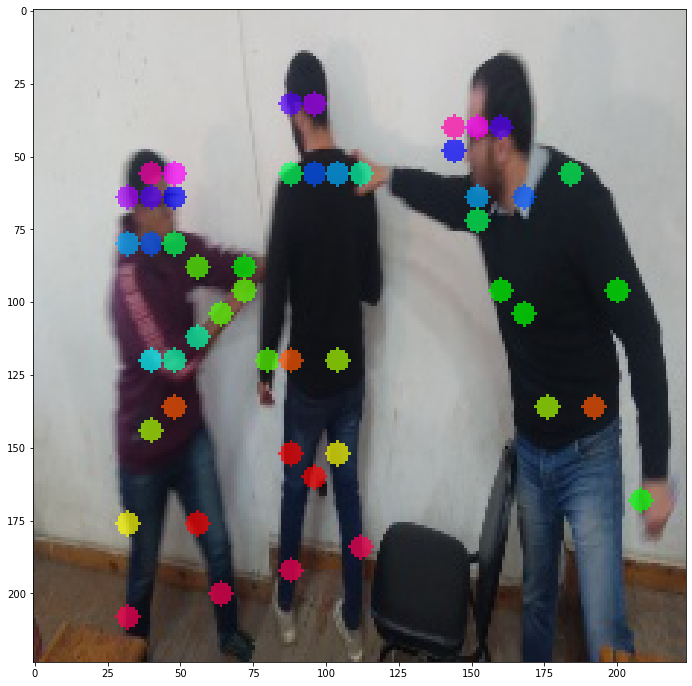

In [16]:
scale = 8

colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cmap = matplotlib.cm.get_cmap('hsv')

canvas = cv2.imread(path) # B,G,R order

for i in range(18):
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
    for j in range(len(all_peaks[i])):
        x = all_peaks[i][j][0] * scale
        y = all_peaks[i][j][1] * scale
        cv2.circle(canvas, (x, y), 4, colors[i], thickness=-1)

to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

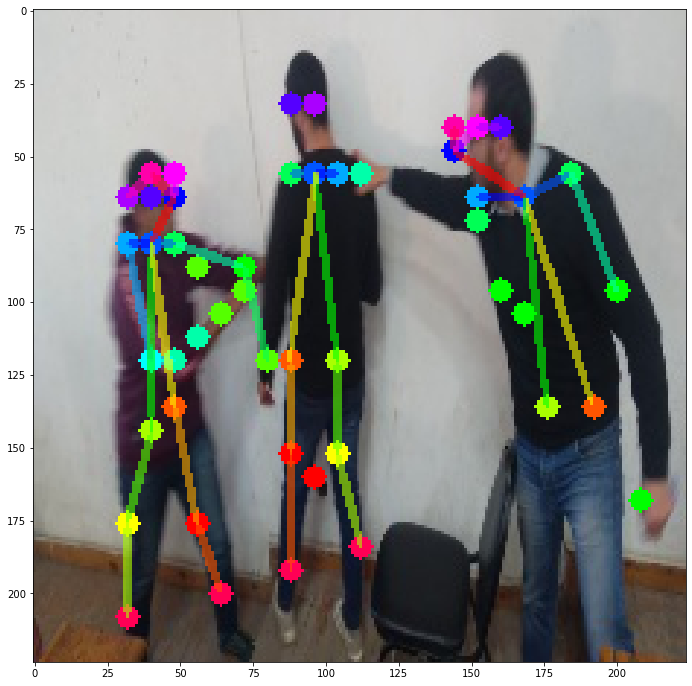

In [17]:
stickwidth = 1

for i in range(17):
    for n in range(len(subset)):
        index = subset[n][np.array(limbSeq[i])-1]
        if -1 in index:
            continue
        cur_canvas = canvas.copy()
        Y = candidate[index.astype(int), 0] * scale
        X = candidate[index.astype(int), 1] * scale
        mX = np.mean(X)
        mY = np.mean(Y)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
        polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
        cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
        canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
        
plt.imshow(canvas[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

Show coordinates of detected body parts with different color for each person

Person: 1
neck ( 96.0 - 56.0 )
right_shoulder ( 104.0 - 56.0 )
left_shoulder ( 88.0 - 56.0 )
right_hip ( 104.0 - 120.0 )
right_knee ( 104.0 - 152.0 )
right_ankle ( 112.0 - 184.0 )
left_hip ( 88.0 - 120.0 )
left_knee ( 88.0 - 152.0 )
left_ankle ( 88.0 - 192.0 )
right_ear ( 96.0 - 32.0 )
left_ear ( 88.0 - 32.0 )
Person: 2
nose ( 144.0 - 48.0 )
neck ( 168.0 - 64.0 )
right_shoulder ( 152.0 - 64.0 )
left_shoulder ( 184.0 - 56.0 )
left_elbow ( 200.0 - 96.0 )
right_hip ( 176.0 - 136.0 )
left_hip ( 192.0 - 136.0 )
right_eye ( 144.0 - 40.0 )
left_eye ( 152.0 - 40.0 )
left_ear ( 160.0 - 40.0 )
Person: 3
nose ( 48.0 - 64.0 )
neck ( 40.0 - 80.0 )
right_shoulder ( 32.0 - 80.0 )
right_elbow ( 40.0 - 120.0 )
right_wrist ( 48.0 - 120.0 )
left_shoulder ( 48.0 - 80.0 )
left_elbow ( 72.0 - 88.0 )
left_wrist ( 80.0 - 120.0 )
right_hip ( 40.0 - 144.0 )
right_knee ( 32.0 - 176.0 )
right_ankle ( 32.0 - 208.0 )
left_hip ( 48.0 - 136.0 )
left_knee ( 56.0 - 176.0 )
left_ankle ( 64.0 - 200.0 )
right_eye ( 40.0 -

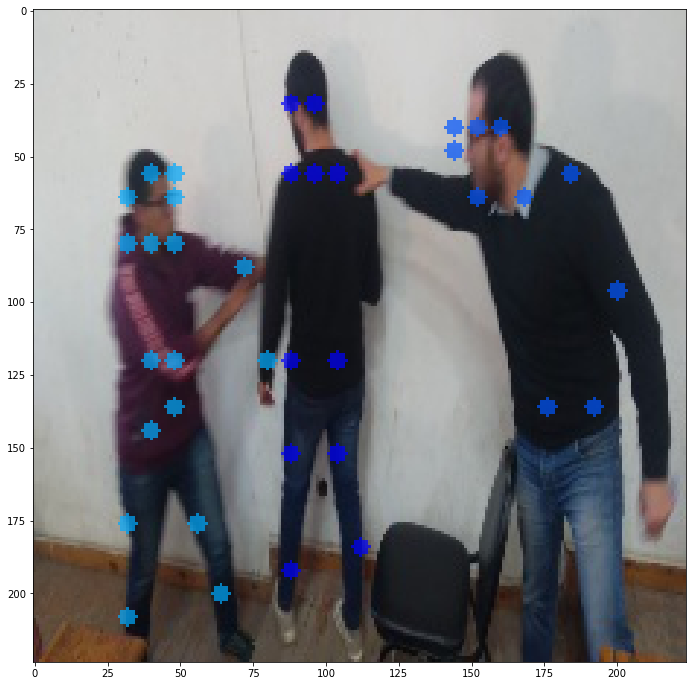

In [18]:
scale = 8
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
canvas = cv2.imread(path) # B,G,R order
for i in range(len(subset)):
    print("Person: " + str(i+1))
    for j in range(len(subset[i])-2):
        cella = subset[i][j]
        if cella != -1:
            X = candidate[cella.astype(int), 0] * scale
            Y = candidate[cella.astype(int), 1] * scale
            cv2.circle(canvas,(int(X), int(Y)), 3, colors[i], thickness=-1,)
            print(hashMap[cella],"(",X,"-",Y,")")
to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)       